<h1><center>Sur l'Ajustement de Valorisation IPV</center></h1>


# Introduction

Le but de cet exercice est d'impliciter la volatilité du sous jacent dans le modèle de Black Scholes et de faire un Ajustement de Valorisation à Valeur Principale d'un call *(le prix que nous donne le pricer)* pour s'approcher de la **Juste Valeur**.

$$\text{Juste Valeur}=\text{Valorisation Principale}+\text{Ajustement de Valorisation (IPV)}$$

Soit $C(\sigma)$ le prix fourni par le pricer d'un call européen de sous jacent une action $A$ dont le prix est $S_0$ à l'émission du contrat, de strike $K=100$ et de maturité $T=1$ an et $C_m$ le prix consensus d'un call avec les mêmes caractéristiques founi par Totem.

On définit la fonction $f$ comme suit :

$$f(\sigma)=C(\sigma)-C_m$$

L'objectif est alors de trouver $\sigma '$ telle que

$$f(\sigma ')=C(\sigma ')-C_m=0$$



Pour faire notre premiere éstimation du prix de ce call nous avons utilisé une volatilité historique $\sigma_h=0.3$

Pour trouver $\sigma '$ nous allons utiliser l'algorithme de Newton Raphson

# Modèle de Black Scholes

## Calcul du taux sans risque

On considère une obligation de maturité M=5ans un notionnel N=100.
On suppose que le coupon de l’obligation est de la forme c_0=ref + s_0
Avec ref un taux de référence par exemple le taux de rendement d’une obligation émise par l’état américain.
A l’émission de l’obligation on actualise les flux future avec le taux c_0=ref + s_0 pour être au pair (Question?)

On a alors le prix initial de l’obligation :
 $$ \pi_0=\pi(s_0)=N.\sum_{i=0}^M B(t_i)(ref+s_0)+N.B(t_n)$$

 avec,

 $$B(t_i)=\frac{1}{(1+ref+s_0)^{t_i}}$$

 On pose maintenant

 $$\pi(s)=N.\sum_{i=0}^M B(t_i)(ref+s)+N.B(t_n)$$

 On a alors,

  $$\pi'(s)=N.\sum_{i=0}^M B(t_i)$$
  
Etant donné un prix $π_{mkt}$ on peut trouver $s_{mkt}$ tel que
$$\pi(s_{mkt})=π_{mkt}=N.\sum_{i=0}^M B(t_i)(ref+s_{mkt})+N.B(t_n)$$
donc
$$s_{mkt}=\frac{\frac{π_{mkt}}{N}-B(t_n)-ref.\sum_{i=0}^M B(t_i)}{\sum_{i=0}^M B(t_i)}$$

On a

In [3]:
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt

In [6]:
OneBP = 0.0001

refRate = 250 * OneBP
s0 = 75 * OneBP

coupon0 = refRate + s0

ParDiscount = coupon0

Notional = 100
Maturity = 1


def BondPrice(refrate, spread, discount, maturity, notional):
    leg = sum([(refrate + spread) / (1 + discount) ** i for i in range(1, maturity + 1)])
    discountEnd = 1 / (1 + discount) ** maturity
    return (leg + discountEnd) * notional



def dBondPrice(discount, maturity, notional):
    return notional * sum([1 / (1 + discount) ** i for i in range(1, maturity + 1)])




def GetSpreadFromPrice(refrate, discount, maturity, notional, price):
    leg = sum([refrate / (1 + discount) ** i for i in range(1, maturity + 1)])
    bpv = sum([1 / (1 + discount) ** i for i in range(1, maturity + 1)])
    discountEnd = 1 / (1 + discount) ** maturity
    return (price / notional - discountEnd - leg) / bpv
    pass



initialPrice = BondPrice(refRate, s0, ParDiscount, Maturity, Notional)

delta = 160 * OneBP

newPrice = BondPrice(refRate, s0 + delta, ParDiscount, Maturity, Notional)

sensi = dBondPrice(ParDiscount, Maturity, Notional)

TehoSpread = GetSpreadFromPrice(refRate, ParDiscount, Maturity, Notional, newPrice) / OneBP

print(f"New price :{newPrice}")

print(f"Initial price + delta * sensi :{initialPrice + delta * sensi}")

print(f"theoSpread - spread0 :{TehoSpread-s0/OneBP}")
print(f"market spread - spread0 :{delta/OneBP}")

MarketRate=(refRate+TehoSpread*OneBP)
print(MarketRate)

New price :101.5496368038741
Initial price + delta * sensi :101.5496368038741
theoSpread - spread0 :160.00000000000065
market spread - spread0 :160.0
0.04850000000000007


On suppose que le prix $S_t$ d'une action A suit la dynamique suivante:

$$dS_t=S_t\left(rdt+\sigma dB_t\right)$$

Avec

$$X_t=ln(S_t)$$

On trouve que

$$dX_t=(r-\frac{\sigma^2}{2})dt+\sigma dB_t$$

Donc

$$X_t=X_0+(r-\frac{\sigma^2}{2})t+\sigma B_t$$

Alors $\forall t\geq 0,$

$$S_t(\sigma)=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma B_t\right\}=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma \sqrt{t} G\right\}$$

Le prix d'un call $C$ s'ecrit sous la forme suivante:

$$\begin{align*}
C(\sigma)&=\mathbb{E}\big\{e^{-rT}(S_T(\sigma)-K)_+\big\}\\
\\
&=\mathbb{E}\big\{\mathbb{1}_{S_T(\sigma)-K>0}e^{-rT}(S_T(\sigma)-K)\big\}\\
\\
&=e^{-rT}\mathbb{E}\big\{S_T(\sigma)\mathbb{1}_{S_T(\sigma)-K>0}\big\}+Ke^{-rT}\mathbb{P}\big\{S_T(\sigma)-K>0\big\}
\end{align*}$$

On a d'un coté

$$\begin{align*}
\mathbb{P}\big\{S_T(\sigma)-K>0\big\}&=\mathbb{P}\big\{(r-\frac{\sigma^2}{2})T+\sigma B_T>ln(\frac{K}{S_0})\big\}\\
\\
&=\mathbb{P}\big\{G>-d_2\big\}
\end{align*}$$

Et vu que $-G$ et $G$ suivent la meme loi,

$$\mathbb{P}\big\{S_T(\sigma)-K>0\big\}=\mathbb{P}\big\{G<d_2\big\}=N(d_2)$$

D'un autre coté On a,

$$\begin{align*}
\mathbb{E}\left\{S_T(\sigma)\mathbb{1}_{S_T(\sigma)-K>0}\right\}&=S_0\mathbb{E}\left\{ e^{(r-\frac{\sigma^2}{2})T+\sigma B_T} \mathbb{1}_{G>d_2}\right\}\\
\\
&=\int_{\mathbb{R}}\mathbb{1}_{G>x}e^{-\frac{x^2}{2}T+\sigma \sqrt{T} x-\frac{\sigma^2}{2}T}\frac{dx}{\sqrt{2\pi}} \\
\\
&=\int_{-d2}^{+\infty}e^{-\frac{x^2}{2}}\\
\\
&=S_0N(d1)
\end{align*}$$

Finalement on trouve que :

$$C(\sigma)=S_0N(d_1)-Ke^{-rT}N(d_2)$$

Où

$$\begin{cases}
      r \text{ : taux d'actualisation} & \\
      \sigma \text{ : la volatilité} & \\
      N \text{: la fonction de répartition de la loi normale}
    \end{cases}$$

Et

$$d_1=\frac{ln\left(\frac{S_0}{K}\right)+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}} \text{ et } d_2=d_1-\sigma\sqrt{T}$$

In [10]:
# !pip install numpy
# !pip install scipy

In [7]:
T=1
S_0=100
r=MarketRate
sigma_h=0.3
K=110
C_m=10


def d1(x):
    return (1/(x*np.sqrt(T)))*(np.log(S_0/K)+(r+0.5*x**2)*T)


def d2(x):
    return d1(x)-x*np.sqrt(T)


def call_ferme(x):
    return S_0*norm.cdf(d1(x))-K*np.exp(-r*T)*norm.cdf(d2(x))

call_ferme(sigma_h)


np.float64(9.9602743324468)

On va chercher alors la racine de la fonction $f$. Pour faire cela nous allons utiliser l'algorithme de Newton Raphson.

------------------------------------------------------------------

**Définiton :**

On utilise l'algorithme de Newton Raphson pour trouver la racine d'une fonction $f$ et est définit itérativement de la manière suivante
 $$\begin{cases}
      x_0=v & \\
      x_{n+1}=x_{n}-\frac{f(x_n)}{f'(x_n)} &
    \end{cases}$$
    
    
-----------------------------------------------------------------


On a

$$f(\sigma)=C(\sigma)-C_m=S_0N(d_1)-Ke^{-rT}N(d_2)-C_m$$

Et on peut monter que

$$\frac{\partial f(\sigma)}{\partial \sigma}=\frac{\partial C(\sigma)}{\partial \sigma}=S_0\sqrt{T}N'(d1)$$

Où
$$N'(x)=\frac{1}{\sqrt{2\pi}}e^{\frac{-x^2}{2}}$$



In [8]:
def f(x):
    return call_ferme(x)-C_m


def dN(x):
    return 1/(np.sqrt(2*np.pi))*np.exp(-x**2/2)


def df(x):
    return S_0*np.sqrt(T)*dN(d1(x))



def newton_raphson(x_0,conf,max_iter,g,dg):
    x_n=x_0
    for i in range(max_iter):
        x_n_plus_1= x_n-g(x_n)/dg(x_n)

        if abs(x_n_plus_1-x_n)<conf:
            return x_n_plus_1
        x_n=x_n_plus_1
    print("solution non trouvé")


sigma_prim=newton_raphson(1,conf=10**-5,max_iter=1000,g=f,dg=df)

sigma_prim

np.float64(0.30099579006505994)

# Calcul de l'Ajusttement de Valorisation

## définition de l'IPV

La **vérification indépendante des prix** est un processus de plus en plus important pour soutenir les fonctions financières et de risque dans un large éventail d'institutions financières. Le processus de base de la IPV exige que les prix internes soient vérifiés par rapport à des sources tierces indépendantes.

Le Prudent Valuation Guidance de Bâle II définit la Vérification Indépendante des Prix comme "le processus par lequel les prix du marché ou les données d'entrée des modèles sont régulièrement vérifiés pour s'assurer de leur exactitude". La vérification des prix du marché ou des données du modèle doit être effectuée par une unité indépendante de la salle des marchés, au moins une fois par mois (ou, selon la nature du marché/de l'activité de négociation, plus fréquemment)".

## Application numérique

### Sensibilité

Le Vega est un type de grecque qui est utilisé pour calculer la sensibilité ou le taux de variation de la valeur d'un contrat d'option par rapport à la volatilité de l'actif sous-jacent. Le Vega est désigné par la lettre $V$. Essentiellement, le vega est la dérivée partielle première de la valeur du contrat d'option par rapport à la volatilité de l'actif sous-jacent.

$$V=\frac{\partial C(\sigma)}{\partial \sigma}(\sigma_h)=S_0\sqrt{T}N'(d1)$$

Où
$$N'(x)=\frac{1}{\sqrt{2\pi}}e^{\frac{-x^2}{2}}$$

In [9]:


sensi=S_0*np.sqrt(T)*dN(d1(sigma_h))

sensi

np.float64(39.89350180537247)

**Remarque :**

En pratique on utilise plutot la formule suivante pour calculer la senbilité:

$$sensi_{bis}=\frac{\partial C(\sigma)}{\partial \sigma}(\sigma_h)=\lim\limits_{\delta \sigma \rightarrow + 0}\frac{C(\sigma_h + \delta \sigma)-C(\sigma_h)}{\delta \sigma}=\frac{C(\sigma_h + 1BP)-C(\sigma_h)}{1BP}$$

In [14]:
sensi_bis=(call_ferme(sigma_h+0.0001)-call_ferme(sigma_h))/0.0001

sensi_bis

np.float64(39.89351401273211)

### IPV ( sensi choc )
----------------

**Définitions :**

* Dans notre contexte, la **choc** est définie comme suit :
$$\text{choc}=\sigma '-\sigma_h$$

* Et on définit l'IPV comme suit :
$$IPV=\text{choc} . sensi = (\sigma '-\sigma_h).sensi$$

---------------

In [15]:
IPV=(sigma_prim-sigma_h)*sensi

IPV

np.float64(0.03972555275824124)

In [16]:
call_ferme(sigma_prim)

np.float64(9.999999999999993)

# Ajustement de valorisation

Finalement, On calcule le proxy de la **Juste Valeur** comme suit :

$$\text{Juste Valeur}=\text{Valorisation principale}+\text{Ajustement de valorisation (IPV)}$$

In [17]:
fair_value=call_ferme(sigma_h)+IPV

fair_value

np.float64(9.999999885205042)

-----------------

**Remarque 1:**
On retombe bien sur une valeur proche du prix sur le marché.

--------------------

-------------------------

**Remarque 2:**

On a grace au développement de Taylor-Young au point $\sigma '$

$$C(\sigma ')\approx C(\sigma_h) +(\sigma '-\sigma_h)\partial_{\sigma}C(\sigma_h)$$

Donc

$$C_m\approx C(\sigma_h) +(\sigma '-\sigma_h).sensi$$

Donc

$$C_m \approx \text{Juste Valeur}$$

----------------------------

# Conclusion

----------------------

**Définition :**

D'après La **norme IFRS 13**, la **"juste valeur"** (ou "fair value" en anglais) se définit comme *"le prix qui serait reçu pour la vente d'un actif ou payé pour le transfert d'un passif lors d'une transaction normale entre des participants de marché bien informés à la date d'évaluation"*.

-------------------
**Conclusion :**

D'après les remarques 1 et 2 on peut conclure que notre démarche nous permet de retrouver la Juste Valeur qui est approximativement la valeur sur le marché.

**************************

# Algorithme de Robbins Monro

soit $f$ une fonction continue telle qu'il existe $F$ une fonction et $U$ une variable aléatoire de loi connue telles que

$$f(x)=\mathbb{E}[F(x,U)]$$

Le but de l'algorithme de Robbins Monro est de trouver, presque surement, $x'$ tel que

$$f(x')=\mathbb{E}[F(x',U)]=0$$

-----------------
**Définition:**

Le théoreme de Robbins Monro stipule que si on définie itérativement une suite de variables aléatoires $(X_n)_{n\geq0}$:

$$\begin{cases}
      X_0= x_0 & \\
      X_{n+1}=X_n-\gamma_nF(X_n,U_{n+1}) &
    \end{cases}$$
    
Où $(\gamma_n)_{n\geq0}$ une suite telle que $\sum_{n\geq0}\gamma_n<\infty$ et $(U_n)_{n\geq0}$ une suite de variables aléatoires idépendantes et identiquement distribuées selon la même loi que $U$.

Alors,
$$X_n \text{ converge presque surement vers }x'$$

----------------

soit la suite de variable aleatoires
$$V_i=e^{-rT}(S_T-K)_{+} - C=e^{-rT}\left(S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma \sqrt{T}G_i\right\}-K\right)_{+} - C=H(\sigma,G_i)$$


Alors avec

$$M_n=\frac{V_0+....+V_n}{n} \text{, $M_n$ converge présque surement vers } \sigma ' $$

J'ai avec $\gamma_n=\frac{1}{n+1}$

$$M_{n+1} = M_n -\gamma_n \left(M_n - V_{n+1}\right)=M_n -\gamma_n \left(M_n - H(\sigma,G_{n+1})\right)= M_n -\gamma_n F \left(M_n , G_{n+1}\right)$$

En effet,

$$\begin{align*}
M_{n+1}-M_n&=\frac{n\sum_{i=1}^{n+1}V_i-(n+1)\sum_{i=1}^nV_i}{n(n+1)}&\\
\\
&=\frac{V_{n+1}}{n+1}-\frac{M_n}{n+1}&\\
\\
&=-\gamma_n(M_n-V_{n+1})\\
\\
&= -\gamma_n F \left(M_n , G_{n+1}\right)\\
\\
\end{align*}$$

<!-- Soit $f(x)=x-C$  et $x'$ tel que $f(x')=x'-C=0$ et $G$ une gaussienne centrée réduite, donc $\mathbb{E}[G]=0$ et $Var[G]=1$.



Finalement je trouve que,

$$f(x)=\mathbb{E}[F(x,G)]=x-C$$ -->


In [18]:
(r+0.14163)/sigma_prim


np.float64(0.6316699644167902)

In [19]:
sigma_prim-r

np.float64(0.25249579006505984)

/tmp/ipython-input-11-1398341512.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return (1/(x*np.sqrt(T)))*(np.log(S_0/K)+(r+0.5*x**2)*T)


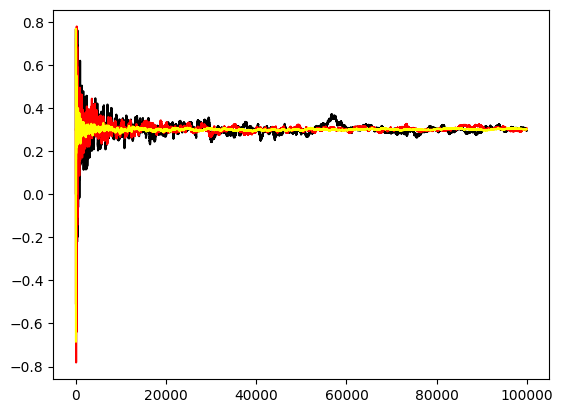

0.2975184563186823


In [20]:
MAX=5
n=100000
beta=1
c=1

Lambda=1.5#(r+0.14163)/sigma_prim

def gamma(n):
    return c/(n+1)**beta

def Theta(n):
    return 1/np.sqrt(n)

def algorithme_rm(x_0,n,F,G):
    X=np.zeros(n)
    X[0]=x_0
    for i in range(0,n-1):
        X[i+1]=X[i]-gamma(i)*F(X[i],G[i+1])
    return X


def algorithme_rm_chen(x_0,MAX,n,F,G):
    X=np.zeros(n);
    X[0] = x_0;
    for i in range(n-1):
        X[i+1]=X[i]-gamma(i)*F(X[i],G[i+1])
        if(abs(X[i+1]) >= MAX):
            X[i+1]=0
    return X




def F_BS(x,U):
    return np.exp(-r*T)*max(S_0*np.exp((r-0.5*x**2)*T+x*np.sqrt(T)*U)-K,0)-C_m


def F_BS_2(x,U):
    return np.exp(-U*Lambda-Lambda**2*0.5)*np.exp(-r*T)*max(S_0*np.exp((r-0.5*x**2)*T+x*np.sqrt(T)*(U+Lambda))-K,0)-C_m


def FP(x,g):
    u=0
    v=0
    if g<=d1(x):
        u=S_0
    else:
        u=0
    if g<=d2(x):
        v=K*np.exp(-r*T)
    else:
        v=0
    return u-v-C_m



G1=np.random.normal(size=n)
G2=np.random.normal(size=n)
G3=np.random.normal(size=n)

# G2=G1
# G3=G1

Y1=algorithme_rm_chen(sigma_prim,sigma_prim*2.6,n,FP,G1)
Y2=algorithme_rm_chen(sigma_prim,sigma_prim*2.6,n,F_BS,G2)
Y3=algorithme_rm_chen(sigma_prim,sigma_prim*2.6,n,F_BS_2,G3)

plt.plot(Y1,'black')
plt.plot(Y2,'red')
plt.plot(Y3,'yellow')


# plt.plot([sigma_prim for i in range(n)],'green')
plt.show()

sigma_prim=Y1[-1]
print(sigma_prim)

# Optimisation du paramètre d'une fonction d'importance

On veut calculer $\mathbb{E}(f(G))$. Avec $\frac{d\mathbb{Q}}{d\mathbb{P}}=e^{-\lambda G - \frac{\lambda^2}{2}}$, on a,
$$\mathbb{E}\left\{e^{-\lambda G - \frac{\lambda^2}{2}} f(G+\lambda)\right\}= \mathbb{E}^{\mathbb{Q}}\left\{f(G+\lambda)\right\}=\mathbb{E}\left\{f(G)\right\}=C$$,


On cherche a minimiser en $\lambda$ la variance de ,
        $$X_\lambda = e^{-\lambda G - \frac{\lambda^2}{2}} f(G+\lambda)$$

***************
**Proposition :**
        $$Var\left\{X_\lambda\right\}= \mathbb{E}\left\{e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\} - \mathbb{E}{f(G)}^2$$,
***************
On a,
$$\begin{align*}
        Var\{X_{\lambda}\}&=\mathbb{E}\left\{(e^{-\lambda G - \frac{\lambda^2}{2}} f(G+\lambda))^2\right\}-\mathbb{E}\{f(G)\}^2\\
&=\mathbb{E}\left\{e^{-\lambda G - \frac{\lambda^2}{2}} g(G+\lambda)\right\}-\mathbb{E}\{f(G)\}^2\\
&=\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2
\end{align*}$$

Avec $g(x)=e^{-\lambda x+\frac{\lambda^2}{2}}f^2(x)$,

On traitera le cas du call dans le modèle de Black et Scholes avec les paramètres suivants\n",
        $r=r_{mkt}$, $\sigma=\sigma'/\mbox{an}$, $S_0=x=100$, $T=1$."

In [ ]:
from math import exp
import math
# r=0.02
sigma=sigma_prim
T=1
x=100
K=100
n=1000
N=1000
def f1(g):
    d=np.size(g);
    S_T=np.zeros(d);
    S_T= x * np.exp((r - sigma*sigma/2)*T*np.ones(d)+sigma*np.sqrt(T)*g);
    return(math.exp(-r*T)*np.maximum(S_T-K*np.ones(np.size(S_T)),np.zeros(np.size(S_T))));

def f(g):
    if(isinstance(g,float) or isinstance(g,int)):
        ST=0;
        ST=float( x * exp((r - sigma*sigma/2)*T+sigma*math.sqrt(T)*g));
        return(exp(-r*T)*max(ST-K,0))
    else:
        d=np.size(g)
        S_T=np.zeros(d)
        S_T= x * np.exp((r - sigma*sigma/2)*T*np.ones(d)+sigma*np.sqrt(T)*g)
        return(math.exp(-r*T)*np.maximum(S_T-K*np.ones(np.size(S_T)),np.zeros(np.size(S_T))))




def approx_variance(Lambda,G):
    # ATTENTION: G est un vecteur echantillon de gaussiennes
    return(np.mean(np.exp(-Lambda*G+0.5*Lambda**2)*f(G)**2)-(np.mean(f(G))**2))

U=np.random.normal(size=n)
approx_variance(1,U)

61.47132044806051

Nous allons voir maintenant quel est le $\lambda$ qui minimise la variance de $X_{\lambda}$

Soit $S_N=\frac{\sum_{n=0}^NVar\{X_{\lambda}\}_n}{N}$

On a alors,

$$S_{N+1}-S_N=\frac{\sum_{n=0}^{N+1}Var\{X_{\lambda}\}_n}{N+1}-\frac{\sum_{n=0}^NVar\{X_{\lambda}\}_n}{N}$$

donc,

$$S_{N+1}-S_N=\frac{NVar\{X_{\lambda}\}_{N+1}-\sum_{n=0}^NVar\{X_{\lambda}\}_n}{N(N+1)}=-\frac{1}{N+1}(S_N-Var\{X_{\lambda}\}_{N+1})$$

donc,

$$S_{N+1}=S_N-\frac{1}{N+1}(S_N-Var\{X_{\lambda}\}_{N+1})$$

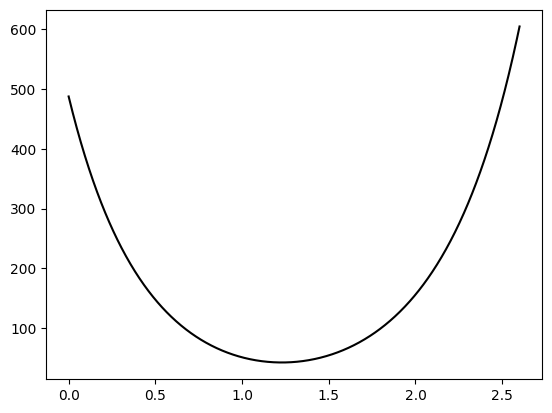

In [ ]:
Lambda = np.linspace(0,2.6,n)
z=np.zeros(np.size(Lambda));
U=np.random.normal(size=n);
mean=np.zeros(np.size(Lambda))
for j in range(500):
    U=np.random.normal(size=n);
    z=np.zeros(np.size(Lambda));
    for i in range(np.size(Lambda)):
        z[i]=approx_variance(Lambda[i],U)
        mean[i]=mean[i]-1/(j+1)*(mean[i]-z[i])
# plt.plot(Lambda,z,'red');
plt.plot(Lambda,mean,'black');

**Proposition :** *la dérivée peut s'écrire sous les deux formes suivantes*\n,
$$\frac{\partial}{\partial \lambda}Var\left(X_\lambda\right)
           =  \mathbb{E}\left\{(\lambda - G)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\}
           =  - \mathbb{E}\left\{ G e^{-2\lambda G - \lambda^2} f^2(G+\lambda)\right\}$$
On a
$$\begin{align*}
\frac{\partial}{\partial \lambda}Var\left(X_\lambda\right)&= \frac{\partial}{\partial \lambda}\mathbb{E}\left\{e^{-\lambda G+\frac{\lambda^2}{2}}f^2(G)\right\}=\mathbb{E}\left\{(\lambda - G)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\}
\end{align*}$$,

D'autre part, avec $h(x)=(\lambda - x)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(x)$,

$$\begin{align*},
\mathbb{E}\left\{(\lambda - G)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\}&= \mathbb{E}\left\{h(G)\right\}\\
&=\mathbb{E}\left\{e^{-\lambda G - \frac{\lambda^2}{2}} h(G+\lambda)\right\}\\
&= - \mathbb{E}\left\{ G e^{-2\lambda G - \lambda^2} f^2(G+\lambda)\right\}
\end{align*}$$

On vérifie ce fait par simulation en tracant les deux approximationsn Monte-Carlo de la dérivées.

On chercher à résoudre $\frac{\partial}{\partial \lambda}Var\left(X_\lambda \right)=0$ en utilisant la première représentation de la dérivée. \n",



Pour cela, on pose $X_0=0$, puis,
$$X_{n+1}=X_n-\gamma_n (X_n - G_{n+1})e^{-X_n G_{n+1} + \frac{X_n^2}{2}} f^2(G_{n+1})$$,
Ou bien,

$$X_{n+1}=X_n +\gamma_n G_{n+1} e^{-2X_n G_{n+1} - X_n^2} f^2(G_{n+1}+X_n)$$


On remarque alors que l'algorithme ne converge pas, $f$ n'est pas continue ?

On implémente cet algorithme en ramenant  $X_n$ une valeur initiale commune lorsque $X_n$ dépasse la valeur de  5  (procédure dite de *projection de Chen*). On peut voir que l'algorithme converge

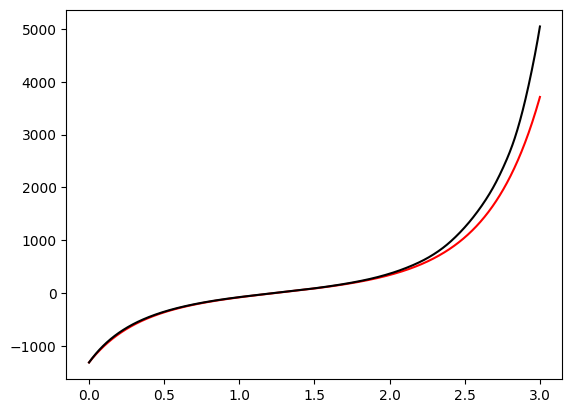

In [ ]:
def approx_1_derivee_variance(Lambda):
    #G=np.random.normal(size=2000)
    Y=(Lambda-G)*np.exp(-Lambda*G+Lambda**2*0.5)*f(G)**2
    return np.mean(Y)

def approx_2_derivee_variance(Lambda):
    #G=np.random.normal(size=2000)
    Y=-G*np.exp(-2*Lambda*G-Lambda**2)*f(G+Lambda)**2
    return np.mean(Y)


K=100;
Lambda=np.linspace(0,3,n)
z1=np.zeros(np.size(Lambda));
z2=np.zeros(np.size(Lambda));
G=np.random.normal(size=n);
mean=np.zeros(np.size(Lambda))
for i in range(np.size(Lambda)):
    z1[i]=approx_1_derivee_variance(Lambda[i]);
    z2[i]=approx_2_derivee_variance(Lambda[i]);
plt.plot(Lambda,z1,'red');
plt.plot(Lambda,z2,'black');

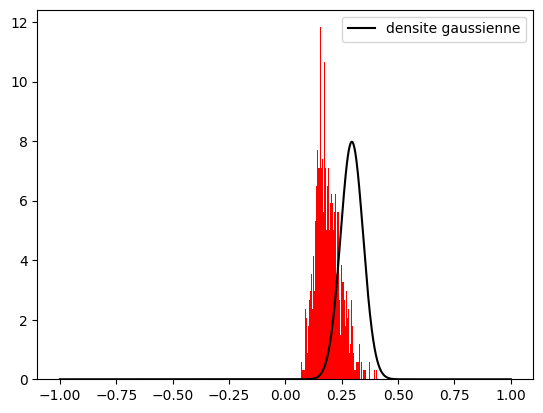

In [ ]:

z=np.zeros(1000);
for i in range(1000):
    U=np.random.normal(size=n);
    X=algorithme_rm_chen(0.1,MAX,n,F_BS,U)
    z[i]=X[-1]

# La densité gaussienne de référence
x = np.linspace(-1,1,1000)
densiteGaussienne = 1./(0.05*np.sqrt(2*np.pi))*np.exp(-0.5*((x-sigma_prim)/0.05)**2)
plt.plot(x, densiteGaussienne,color='black', label="densite gaussienne")
plt.legend(loc="best")

plt.hist(z, color="red", density="True", bins=100, label="erreur normalisee");

***********************
**Théorème:**(Loi des grands nombres pour les martingale)

Soit $(S_n)_{n\geq0}$ une martingale de carrée integrable, on a alors:

 +*Sur* $\langle S\rangle_\infty:=\lim_{n\rightarrow \infty}\langle S\rangle_n<\infty$ $S_n$ *converge présque surement vers une variable :$S_\infty$,

+*Sur* $\{\langle S\rangle_\infty=\infty\}$
          $$\lim_{n\rightarrow\infty}\frac{S_n}{\langle S\rangle_n}=0 \text{ , p.s}$$

En plus, si $a(t)$ est une fonction positive, croissante telle que

$\int_0^{\infty}\frac{dt}{1+a(t)}<\infty$,
alors,
       $$\lim_{n\rightarrow \infty}\frac{S_n}{\sqrt{a(\langle S\rangle_n)}}=0\text{ , p.s}$$
   
***********************   

***********************

**Proposition:** Avec les même notations, on pose $S_0=0$ et $S_n=nM_n, \forall n >0$, alors $(S_n)_{n\geq0}$ est une martingale,et $\langle S\rangle_n=n\left(\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2\right)$

***********************
On a

$$\begin{align*}
        \mathbb{E}\left\{S_{n+1}\mid\mathcal{F}_n\right\}&=\mathbb{E}\left\{V_1+...+V_V+V_{n+1}\mid\mathcal{F}_n\right\}\\
 &=V_1+...+V_n+0=S_n
 \end{align*}$$


Donc $(S_n)_{n\\geq0}$ est une martingale, en plus $\langle S\rangle_0=0$, et $\forall n>0$


Avec $g(x)=e^{-\lambda x+\frac{\lambda^2}{2}}f^2(x)$,

$$\langle S\rangle_{n+1}-\langle S\rangle_n=\mathbb{E}\left\{(S_{n+1}-S_n)^2\mid\mathcal{F}_n\right\}=Var\{V_{n+1}\}=\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2$$

Donc


$$\langle S\rangle_n=\sum_{k=0}^{n-1}\langle S\rangle_{k+1}-\langle S\rangle_k=n\left(\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2\right)$$



Donc $\langle S\rangle_\infty=\infty$, et en utilisant le théorème précédant on retrouve la loi forte des grands nombre. \n",

On a alors
$$\lim_{n\rightarrow\infty}\frac{V_1+...+V_n}{n\left(\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2\right)}=0 \text{  p.s}$$


**Remarque:**   Pour avoir une idéé sur la vitésse de convergence, on utilise la fonction $a(t)=Ct^{2-\beta}$, pour $\frac{1}{2}<\beta<1$, on trouve alors en faisant les changements de variables $k=2-\beta$ et dans l'integration $u=(C^{\frac{1}{k}}t)$ et $x=\frac{1}{1+u^k}$  que:,

$$\begin{align*}
\int_0^\infty\frac{dt}{1+a(t)}&=C^{\frac{-1}{k}}\int_0^\infty\frac{du}{1+u^k}\\
  &=\frac{C^{\frac{-1}{k}}}{k}\int_0^1x^{(1-\frac{1}{k})-1}(1-x)^{\frac{1}{k}-1}dx\\
  &=\frac{C^{\frac{-1}{k}}}{k}\beta\left(\frac{1}{k},1-\frac{1}{k}\right)<\infty
\end{align*}$$

On a alors avec $\gamma_n=\frac{C}{n^\beta}$,

$$\lim_{n\rightarrow\infty}\frac{S_n}{\sqrt{a(\langle S \rangle_n)}}=0 \text{ , p.s}$$",
        

In [ ]:
# def approx_variance(Lambda,G):
#     # ATTENTION: G est un vecteur echantillon de gaussiennes
#     return(np.mean(np.exp(-Lambda*G+0.5*Lambda**2)*f(G)**2)-(np.mean(f(G))**2))

G=np.random.normal(size=n)

u=approx_variance(1,G)
u

52.79582465175426

In [ ]:
[1,2,3,4,5,6][2:]

[3, 4, 5, 6]

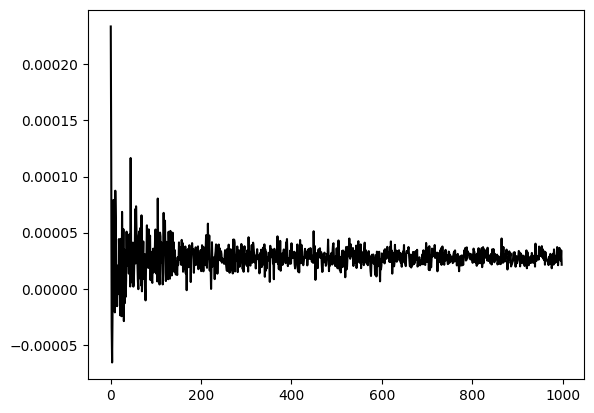

In [ ]:
G=np.random.normal(size=n)

def a(t):
    return c*t**(2-beta)
P=[]
Q=[]
for i in range(1,1000):
    G2=list(np.random.normal(size=i))
    Mn=[F_BS(sigma_prim,g)/u**2 for g in G2]
    sample=np.mean(Mn)
    P.append(sample)
    Q.append(sum(Mn)/a(i*u))

#plt.plot(P,'red')
plt.plot(Q,'black')

# Equation de la chaleur et pricing de Call Europeen

On suppose toujours que la dynamique d'une action A suit est la suivante

$$dS_t=S_t\left(rdt+\sigma dB_t\right)$$

$$$$

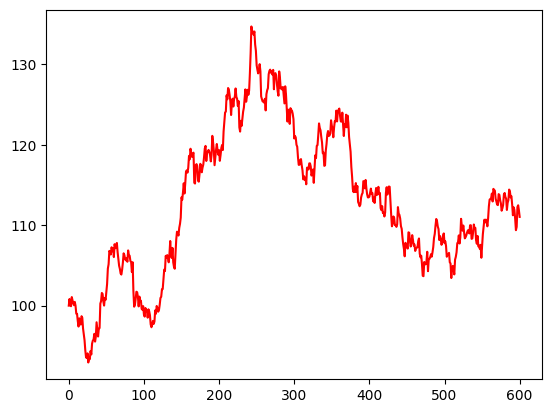

In [ ]:
dt=0.001
G=list(np.random.normal(0,1,size=600))
S=[S_0]

for i in range(0,len(G)):
    S.append(S[i]+S[i]*(r*dt+sigma_h*G[i]*1*dt**0.5))

plt.plot(S,'red')



soit maintenant la fonction:

$$u(t,S_t):=\mathbb{E}\big\{e^{-r(T-t)}f(S_T)\mid\mathbb{F}_t\big\}$$

et soit

$$Z_t:=e^{-rt}u(t,S_t)=\mathbb{E}\big\{e^{-rT}f(S_T)\mid\mathbb{F}_t\big\}$$

Alors $Z_t$ est une martingale, en effet on a pour $s\leq t$:

$$\mathbb{E}\big\{Z_t\mid\mathbb{F}_s\big\}=\mathbb{E}\big\{\mathbb{E}\big\{e^{-rT}f(S_T)\mid\mathbb{F}_t\big\}\mid\mathbb{F}_s\big\}=\mathbb{E}\big\{e^{-rT}f(S_T)\mid\mathbb{F}_s\big\}=Z_s$$

d'autre part on a d'apres le lemme d'Ito,

$$dZ_t=e^{-rt}\big\{\partial_tu+rS_t\partial_xu+\frac{1}{2}\sigma^2S^{2}_t\partial^{2}_xu-ru\big\}dt+e^{-rt}\sigma S_tdB_t$$

or $Z_t$ est une martingale, donc,
$$\partial_tu+rS_t\partial_xu+\frac{1}{2}\sigma^2S^{2}_t\partial^{2}_xu-ru=0$$

## discretisation avec différences finies
 soit une discretisation du temps et du prix :
 $$\begin{cases}
      t_0\leq t_1\leq ...\leq t_n \leq...\leq t_N=T\\
      0\leq 1\leq ...\leq j\leq...\leq 2K &
    \end{cases}$$

On aproxime la solution $u(t_n,j)$ avec la discretisation suivante


 $$\begin{cases}
      \partial_tu =\frac{u^{t+1}_j-u^t_j}{dt} \\
      \partial_xu =\frac{u^t_{j+1}-u^t_{j-1}}{2dx}\\
      \partial^{2}_xu=\frac{u^t_{j+1}+u^t_j-2u^t_{j-1}}{dx^2}
    \end{cases}$$
    
On remplace dans notre équation et on trouve

$$u^{t+1}_j=u^t_{j-1}\big(\frac{v_1c_1}{2}+v_2c_2\big)+u^t_j\big(1+v_1c_1+rdt\big)+u^t_{j+1}\big(\frac{v_1c_1}{2}-\frac{v_2c_2}{2}\big)$$

avec

$$\begin{cases}
      v_1=\frac{dt}{dx^2} \\
      v_2=\frac{dt}{dx}\\
      c_1=\sigma^2S^{2}\\
      c_2=rS
    \end{cases}$$

True


C:\Users\oessadde040723\AppData\Local\Temp\ipykernel_22540\555677718.py:35: RuntimeWarning: overflow encountered in scalar multiply
  u[s_steps] = 2*u[s_steps-1] - u[s_steps-2]
C:\Users\oessadde040723\AppData\Local\Temp\ipykernel_22540\555677718.py:31: RuntimeWarning: overflow encountered in scalar multiply
  u[j] = temp1*u_prev[j-1] + temp2*u_prev[j] + temp3*u_prev[j+1]
C:\Users\oessadde040723\AppData\Local\Temp\ipykernel_22540\555677718.py:35: RuntimeWarning: invalid value encountered in scalar subtract
  u[s_steps] = 2*u[s_steps-1] - u[s_steps-2]
C:\Users\oessadde040723\AppData\Local\Temp\ipykernel_22540\555677718.py:31: RuntimeWarning: overflow encountered in scalar add
  u[j] = temp1*u_prev[j-1] + temp2*u_prev[j] + temp3*u_prev[j+1]
C:\Users\oessadde040723\AppData\Local\Temp\ipykernel_22540\555677718.py:53: RuntimeWarning: divide by zero encountered in log
  d1 = 1/(vol*sqrt(time_max))*log(s/strike) + (r + vol**2/2)*time_max


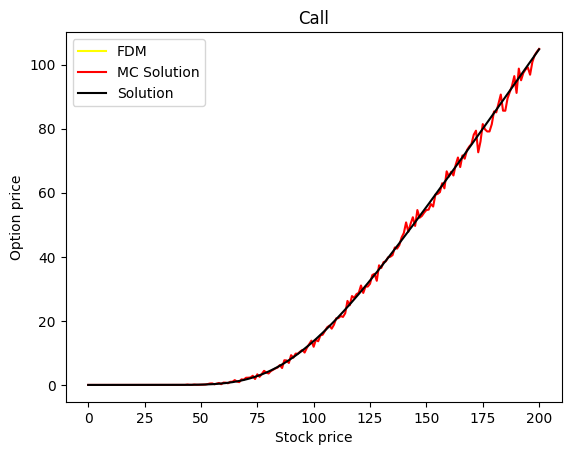

In [ ]:
from numpy import *
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm




def fdm_call(vol, r, strike):

    print(dt <= 1/(vol**2*s_steps**2))

    spanS = [startS+s*ds for s in range(s_steps+1)]
    u = [max(s - strike, 0) for s in spanS]

    v1 = dt/ds**2
    v2 = dt/ds


    soln_grid = []
    for i in range(t_steps+1):
        u_prev = u
        for j in range(1, s_steps):
            coeff = vol**2*spanS[j]**2
            coeff1 = r*spanS[j]

            temp1 = v1*coeff/2 + v2*coeff1
            temp2 = 1 + v1*coeff + dt*r
            temp3 = v1*coeff/2 - v2*coeff1/2

            u[j] = temp1*u_prev[j-1] + temp2*u_prev[j] + temp3*u_prev[j+1]


        u[0] = 0
        u[s_steps] = 2*u[s_steps-1] - u[s_steps-2]

        soln_grid.append(array(u))




    def F_BS(x,U,S_0):
        T=1
        return np.exp(-r*T)*max(S_0*np.exp((r-0.5*x**2)*T+x*np.sqrt(T)*U)-K,0)

    MC_sol=[]
    bs_soln = []

    for s in spanS:
        G=np.random.normal(size=600)
        MC_sol.append(np.mean([F_BS(sigma_prim,g,s) for g in G]))

        d1 = 1/(vol*sqrt(time_max))*log(s/strike) + (r + vol**2/2)*time_max
        d2 = d1-vol*sqrt(time_max)
        val = norm.cdf(d1)*s-norm.cdf(d2)*strike*exp(-r*time_max)
        bs_soln.append(val)

    return spanS, soln_grid, bs_soln, MC_sol




def graphs(spanS,soln_grid,bs_soln,mc_sol,option):
    final_soln = soln_grid[len(soln_grid)-1]
    plt.plot(spanS, final_soln,'yellow', label = 'FDM')
    plt.plot(spanS, mc_sol,'red', label = 'MC Solution')
    plt.plot(spanS, bs_soln,'black', label = 'Solution')

    plt.plot()
    plt.legend(loc=2)
    plt.xlabel("Stock price")
    plt.ylabel("Option price")
    plt.title(option)




vol = sigma_prim

strike = K


time_max = 1
dt = .0001

startS = 0
endS = 2 * strike
ds = 1

s_steps = int((endS-startS)/ds)

t_steps = int(time_max/dt)


spanS, soln_grid_C, bs_soln_C, MC_sol = fdm_call(vol,r,strike)
graphs(spanS,soln_grid_C,bs_soln_C,MC_sol,"Call")


# Systeme de particules

Soit

$$X_t=log(St)$$


Alors,

$$dX_t=\mu dt+\sigma dB_t$$

On definit alors la suite

$$X_{k+1}=X_k+\mu dt +Y_k \text{ou , }Y_k \sim N(0,\sigma^2 d t)$$

On veut estimer la probalilité:

$$p=\mathbb{P}\big(X_T> x\big) \text{, avec,  } x=log(K)$$
**************
**Theorem de Radon-Nikodym**

Soient $(\Omega, \mathbb{F}, \mu)$ un espace mesuré $\sigma$ fini et $\eta$ une mesure sur $(\Omega, \mathbb{F})$
Si $\eta$ absolument continue par rapport à $\mu$, alors si il existe une fonction $f$ $\mathbb{F}$-Mesurable telle que

$$\eta (A)=\int_A f d\mu$$

La fonction f est appeleé dérivé de Radon Nikodym et

$$f=\frac{d\eta}{d\mu}$$

*****************

**Preuve**


On veut montrer qu'il existe une fonction  $f\in L^1(\mu)$ telle que

$$∀ A\in \mathbb{F}, ∫_Afd\mu=\eta (A)$$
Definisons l'operateur $T$ sur $L^{∞}(\mu)$
$$\forall \phi\in L^{∞}(\mu), T(\phi)=∫_X\phi d\eta$$

Alors
+ $T$ est bien defini car $\phi$ est borné et $\eta$ est une mesure finie
+ $T$ est un operateur positif
+$T$ est continu car $\mid T(\phi)\mid=\mid∫_X\phi d\eta\mid\leq\mid\mid\phi\mid\mid_{∞}\eta(X)$

Le Theoreme de representation de Riesz pour l'espace $L^{∞}(\mu)$ affirme que tout operateur continue positif sur $L^{∞}(\mu)$ est donné par l'integration contre une fonction;

 $$∃f\in L^1(\mu)\text{ telle que }∀\phi\in L^{∞}(\mu), T(\phi)=∫_Xf\phi d\mu$$

 en prenant $\phi=\mathbb{1}_A$ on trouve que
 $$∫_Afd\mu=\eta (A)$$

maintenant, pour l'unicité de $f$, on suppose $f_1, f_2$ telles que

$$\eta (A)=∫_Af_1d\mu=∫_Af_2d\mu$$

donc,

$$0=∫_A(f_1-f_2)d\mu$$

Donc $f$ est unique $\mu$ $P.P$


**********************
**Theorem de Riesz**

Soit $ (X,\mathbb{F},\mu)$ un espace mesuré avec $\mu$ une mesure positive.
Soit

$$T: L^{∞}(\mu)→\mathbb{R}$$
Un fonctionel lineaire, continue et positif

Alors, il existe une fonction $f\in  L^{1}(\mu)$, $f\geq0$

presque partouttelle que:

$$∀\phi\in  L^{∞}(\mu), T(\phi)=∫_Xf\phi d\mu$$
****************
**Preuve**



**A : Construction des partition $P_n=\{A^{(n)}_j\}_{j=0}^{N^n}$ tels que**

+ Chaque $A^{(n)}_j$ est reunion d'elements de $P_{n+1}$
+  On suppose que $𝑼_{n}P_n$ engendre la tribu $\mathbb{F}$

+ sur chaque partition $A^{(n)}_j$ on definit :

$$f_n(x)=\frac{T(\mathbb{1}_{A^{(n)}_j})}{\mu(A^{(n)}_j)} \text{, si }x\in A^{(n)}_j$$

**B : Propriétés de la suite $(f_n)_n$**

 chaque $f_n$ est une fonction simple mesurable, constante sur chaque $A^{(n)}_j$

Par positivité de $T$ on a,

$$f_n(x)\geq 0,   \text{ $\mu$ P.P}$$

On a aussi

$$\begin{align*}
\mid\mid f_n\mid\mid_{L^{∞}(\mu)}&=\sum_jf_n(x_j)\mu(A^{(n)}_j)\\
  &=\sum_jT(\mathbb{1}_{A^{(n)}_j})\\
  &=T\Big(\sum_j\mathbb{1}_{A^{(n)}_j}\Big)\\
  &=T(1)<\infty
\end{align*}$$

**$f_n$ est une martingale, Montrons que**
$$\mathbb{E}\Big\{f_{n+1}\mid \mathbb{F}_n\Big\}(x)=f_n(x)$$

Soit $x\in A^{(n)}_j$, On a

$$f_n(x)=\frac{T(\mathbb{1}_{A^{(n)}_j})}{\mu(A^{(n)}_j)}$$

Or,
$$A^{(n)}_j=\bigcup_{k\in I_j}A^{(n+1)}_k$$

 Ou $I_j$ l'ensemble des indice $k$ tels que $A^{(n+1)}_k\subset A^{(n)}_j $, et on a

 $$T(\mathbb{1}_{A^{(n)}_j})=\sum_{k\in I_j}T(\mathbb{1}_{A^{(n+1)}_k})$$

Donc,

$$f_n(x)=\frac{\sum_{k\in I_j}T(\mathbb{1}_{A^{(n+1)}_k})}{\mu(A^{(n)}_j)}$$

On a aussi pour $x\in A^{(n+1)}_k\subset A^{(n)}_j $

$$f_{n+1}(x)=\frac{T(\mathbb{1}_{A^{(n+1)}_k})}{\mu(A^{(n+1)}_k)}$$

On a ,

$$\mathbb{E}\Big\{f_{n+1}\mid \mathbb{F}_n\Big\}(x)=\frac{1}{\mu(A^{(n)}_j)}∫_{A^{(n)}_j}f_{n+1}(y)d\mu(y)$$

Or, $f_n$ est constante sur chaque $A^{(n+1)}_k$, donc

$$\begin{align*}
∫_{A^{(n)}_j}f_{n+1}(y)d\mu(y)&=\sum_{k\in I_j}∫_{A^{(n+1)}_k}f_{n+1}(y)d\mu(y)\\
&=\sum_{k\in I_j}f_{n+1}(x_k)\mu(A^{(n+1)}_k)
\end{align*}$$

Don,

$$\begin{align*}
\mathbb{E}\Big\{f_{n+1}\mid \mathbb{F}_n\Big\}(x)&=\frac{\sum_{k\in I_j}\frac{T(\mathbb{1}_{A^{(n+1)}_k})}{\mu(A^{(n+1)}_k)}\mu(A^{(n+1)}_k)}{\mu(A^{(n)}_j)}\\
&=\frac{\sum_{k\in I_j}T(\mathbb{1}_{A^{(n+1)}_k})}{\mu(A^{(n)}_j)}\\
&=\frac{T(\mathbb{1}_{A^{(n)}_j})}{\mu(A^{(n)}_j)}\\
&=f_n(x)
\end{align*}$$

**Convergence p.p et $L^{1}(\mu)$**

avec le theoreme de convergence des martingales, la suite $f_n$ converge vers une fonction $f\in L^{1}(\mu)$

**Representation de $T$**

Pour toute fonction simple $\phi$ mesurable

$$\begin{align*}
T(\phi)&=\sum_j \phi(x_j)T(\mathbb{1}_{A^{(n)}_j})\\
&=\sum_j \phi(x_j)f_n(x_j)\mu(A^{(n)}_j)\\
&=\int_Xf_n\phi d\mu
\end{align*}$$
Par passage à la limite, on trouve que
$$T(\phi)=\int_Xf\phi d\mu$$
enfin par densité des fonctions simple dans $L^{∞}(\mu)$ on trouve que

$$∀\phi\in L^{∞}(\mu) , T(\phi)=\int_Xf\phi d\mu$$
*********
Dans notre cas on définit

**la mesure $\mathbb{P}$** La mesure sous laquelle

$$X_t=log(S_t), \text{ suit la dynamique suivante } dX_t = \mu dt+\sigma dB_t$$


**la mesure $\mathbb{Q}^\theta$** La mesure sous laquelle le precessus suit la dynamique

$$dX_t = (\mu-\sigma\theta)dt+\sigma dB_t$$

Donc

$$\mathbb{E}\Big\{f_{n+1}\mid \mathbb{F}_n\Big\}(x)=f_n(x)$$

avec

$$\theta=\frac{x-log(S_0)-\mu T}{\sigma \sqrt{T}}$$

D'apres le theoreme de girsanov, la dérivé de Radon Nikodym est :

$$L_T=\frac{d\mathbb{Q}^\theta}{d\mathbb{P}}=exp\Big\{\theta\int_0^TdB_s-\frac{1}{2}\theta^2T\Big\}$$

en utilisant la propriéte d'Ito, on trouve que $\int_0^TdB_s=B_T$, donc


$$L_T=exp\Big\{\theta B_T-\frac{1}{2}\theta^2T\Big\}$$

et

$$B_T=\frac{X_T-X_0-\mu T}{\sigma}=\frac{Y_T}{\sigma}$$

donc

$$L_T=exp\Big\{\theta \frac{X_T-X_0-\mu T}{\sigma}-\frac{1}{2}\theta^2T\Big\}=exp\Big\{\frac{\theta}{\sigma} Y_T-\frac{1}{2}\theta^2T\Big\}$$

En utilisant le théorème de Raddon Nikodym on trouve que

$$I=\mathbb{E}^{\mathbb{P}}\Big\{\mathbb{1}_{\{X_T>x\}}\Big\}=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{\frac{1}{L_T} \mathbb{1}_{\{X_T>x\}}\Big\}$$



et

$$\frac{1}{L_T}=exp\Big\{-\theta \frac{X_T-X_0-\mu T}{\sigma}+\frac{1}{2}\theta^2T\Big\}=exp\Big\{-\frac{\theta}{\sigma} Y_T+\frac{1}{2}\theta^2T\Big\}$$


$\frac{1}{L_T}$ est bornée en moyenne:

$$\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{\frac{1}{L_T}\Big\}=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{\frac{d\mathbb{P}}{\mathbb{Q}^{\theta}}\Big\}=1$$



$$I=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{\frac{1}{L_T} \mathbb{1}_{\{X_T>x\}}\Big\}=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{exp\Big\{\frac{-\theta Y}{\sigma}+\frac{1}{2}\theta^2T\Big\} \mathbb{1}_{\{X_T>x\}}\Big\}=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{exp\{\frac{-\theta Y}{\sigma}\} \mathbb{1}_{\{X_T>x\}}\Big\}exp\{\frac{1}{2}\theta^2T\}$$

## Convergence Monte Carlo



$$\prod^{n-1}_{k=0}\frac{1}{M}\sum_{j=1}^Mexp\big\{\frac{\theta}{\sigma}Y_k^{(j)}\big\}$$

$$\text{ converge preseque surement vers, } exp\{\frac{1}{2}\theta^2T\}\text { quand } n,M\rightarrow \infty$$

d'une autre part,

$$\prod^{n-1}_{k=0}\frac{1}{M}\sum_{j=1}^Mexp\big\{\frac{\theta}{\sigma} Y_k^{(j)}\big\}\frac{1}{M}\sum_{j=1}^M\mathbb{1}_{\{X_n^{(j)}>x\}}exp(-\frac{\theta}{\sigma} Y_n)$$

$$\text{ converge preseque surement vers, } I=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{exp\{\frac{-\theta Y}{\sigma}\} \mathbb{1}_{\{X_T>x\}}\Big\}exp\{\frac{1}{2}\theta^2T\}=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{\frac{1}{L_T} \mathbb{1}_{\{X_T>x\}}\Big\}\text { quand } n,M\rightarrow \infty$$


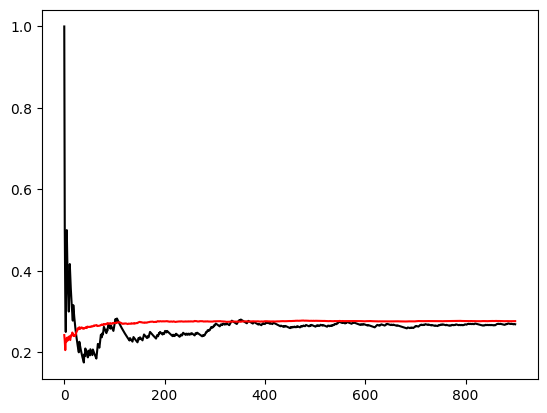

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

K=120
S_0=100
sigma=sigma_prim
r=0.05
T=1
# temps
n=90
st=T/n

dt=1/n
# nb particule
M=60

#nb simulation
N=900

x=np.log(K)

mu=r-0.5*sigma**2

theta=(x - np.log(S_0) - mu*T)/(sigma*np.sqrt(T))



means=[]
cumul_sum=0

for i in range(1,N+1):
    #Y=np.random.normal(0,1,M)*(sigma*np.sqrt(dt))
    #X=np.log(S_0)+mu*dt+Y
    X=np.full(M,np.log(S_0))
    norm=1

    #temps
    for k in range(1,n):

        Y=np.random.normal(0,sigma*np.sqrt(dt),M)

        X+=mu*dt+Y



        G=np.exp(theta/sigma*Y)
        norm*=np.mean(G)

        w=G/np.sum(G)
        cdf=np.cumsum(w)
        u0=np.random.uniform(0,1/M)
        u=u0+np.arange(M)/M
        ind=np.searchsorted(cdf,u)
        X=X[ind]

    Y_final=X-np.log(S_0)-mu*T
    weightsFinal=np.exp(-theta/sigma*Y_final)
    indicators=(X>x).astype(float)
    estimate=norm*np.mean(indicators*weightsFinal)

    cumul_sum+=estimate
    means.append(cumul_sum/i)




X_T=np.log(S_0)+mu*T+sigma*np.sqrt(T)*np.random.randn(N)

indicators=(X_T>np.log(K)).astype(float)

pEstimate=np.mean(indicators)

MeansNaive=np.cumsum(indicators)/np.arange(1,N+1)
MeanNaive=np.mean(indicators)
plt.plot(MeansNaive,'black')
plt.plot(means,'red')
# plt.plot([MeanNaive for _ in range(len(indicators))],)




# Calcul de Malliavin et grecs

## Notations et définitions

***********************
### Notation

On considère un espace de probabilité $(Ω,\mathbb{F},\mathbb{P})$ sur lequel est défini un mouvement brownien $(B_t)_{t\geq 0}$ et on note $\mathbb{F}_t=\sigma(B_s,s\leq t)$.

On subdivise l'interval $[0,T]$ à l'aide des dyadique $t^n_k=\frac{k}{2^n} $ avec $n\in\mathbb{N}^*$ et $k\in\{0,...,2^n\}$

Enfin, on note $Δ^n_k=B_{t^n_{k+1}}-B_{t^n_{k}}$, les acroissement du brownien et $Δ^n=(Δ^n_0,...,Δ^n_{2^n-1})$

On introduit les espace simples sur lesquels on va définir nos deux operateur. $C^∞_p$ designe l'ensemble des fonctions infiniment derivables à croissance au plus polynomial
*********
**************
### Définitions
**Définition 1**

l'ensemble des fonction simples

$$S_n=\Big\{f(Δ^n_0,...,Δ^n_{2^n-1}); f\in C^∞_p(\mathbb{R}^{2^n}) \Big\}$$

les $S_n$ forment une suite croissante d'ensembles inclus dans $L_2(Ω)$, les éléments de $S=⋃ _{n\geq 0}S_n$  s'appellent fonctionnelles simples.

Cet ensemble nous permettera de définir la dérivé de Malliavin. L'espace des fonctionnelles simple est construit de telle sorte qu'apparaise clairement la dépendance d'une variable aléatoire de $S_n$ avec les accroissement du brownien
************
**********
**Définition 2**
l'ensemble des processus simples

$$P_n=\Big\{\sum _{i=0}^{2^n-1}𝟙 _{[t^n_i,t^n_{i+1}[}(t)F_i(ω)\text{ ;  } (t,ω)\in [0,T],Ω\text{ et } F_i\in S_n\Big\}$$

Les $P_n$ forment une suite croissante d'ensemble inclus dans $L_2([0,T]\times Ω)$.

Les element de $P=⋃_{n\geq1}P_n$ s'appellent processus simples.
*************
***********
**Définition 3**

soit $F\in S$, alors $∃n\in \mathbb{N}^*$tel que

$$F=f(Δ^n)$$
L'operateur de dérivation au sens de Malliavin de la fonctionelle simple $F$ en un point $s\in [t^n_i,t^n_{i+1}[$ est alors la fonction

$$D_sF=\sum _{i=0}^{2^n-1}𝟙 _{[t^n_i,t^n_{i+1}[}(s)∂_if(Δ^n)$$
Il est logique que cet operateur associe à une variable aléatoire un processus.

A la date $s$ la dérivée au sens de Malliavin traduit l'impacte des acroissement du brownien sur une variable aléatoire
***************
****************
**Définition 4 : l'operateur de dérivation de Skorokhod**

Soit $u\in P$, alors $∃n\in\mathbb{N}^*$ tel que $u\in P_n$.L'operateur d'integration au sens de Skorokhos du processus simple $u$ est

$$δ(u)=\sum _{i=0}^{2^n-1}f_i(Δ^n)Δ^n_i-\sum _{i=0}^{2^n-1}∂_if_i(Δ^n)\frac{1}{2^n}$$
avec

$$u(t,ω)=\sum _{i=0}^{2^n-1}𝟙 _{[t^n_i,t^n_{i+1}[}(t)F_i(ω) \text{ et } F_i=f_i(Δ^n)$$

Notons que le premier terme correspond à une integrale d'Ito, le second prend en compte le fait que le processus n'est pas necessairement adapté. Ce deuxieme terme est necessaire pour obtenir la relation d'integration par partie et a été integré dans la définition dans ce but.

Si on définit les processus prévisible par
$$∀k\in \big\{0,...,2^n-1\big\}, f_k(Δ^n)=f_k(Δ^n_0,...,Δ^n_{k-1})$$
On remarque que dans ce cas le deuxieme terme s'annule
**********
## Extention des operateur
Nous allons maintenant etendre les operateur $D$ et $δ$ à $L_2(Ω)$, $L_2([0,T],Ω)$
***********
**Proposition**

$D$ et $δ$ sont des operateur férmés, c'est à dire si $(F_n)_n$ est une suite de $S$ qui tends vers $0$ dans $L_2([0,T],Ω)$ et si $DF_n$ tends vers $u$ alors, $u=0$
************
************
**Définition 5**

On définit
$$\mathbb{D}^{1,2}=\Big\{F\in L_2(Ω) \text{ tq }∃(F_n)\in S\text{ tq }F_n\xrightarrow{L_2(Ω)}F \text{ et }DF_n\xrightarrow{L_2([0,T],Ω)}u\Big\}$$

on pose alors

$$Df=u$$
******************

*************
**Définition 6**

On définit

$$Dom(δ)=\Big\{u\in L_2([0,T],Ω) \text{ tq }∃(u_n)\in P \text{ tq }u_n\xrightarrow{L_2([0,T],Ω)}u \text{ et }\delta (u_n)\xrightarrow{L_2(Ω)}F\Big\}$$

On pose alors

$$F=δ(u)$$
**********

## formule d'integration par partie

************
**Proposition 1**

$∀F\in \mathbb{D}^{1,2}$ et $∀u\in Dom(δ)$

$$\mathbb{E}\Big\{∫_0^TD_sFu_sds\Big\}=\mathbb{E}\big\{Fδ(u)\big\}$$
On a donc la relation
$$\Big<DF,u\Big>_{L_2([0,T],Ω)}=\Big<F,\delta( u)\Big>_{L_2(Ω)}$$
**************
************
**Lemme 1**

Soit $Δ\sim N(0,σ^2)$, alors pour $f,g$ dans $C^1(\mathbb{R})$

$$\mathbb{E}\big\{f'(Δ)g(Δ)\big\}=\mathbb{E}\Big\{f(Δ)\big(\frac{Δ}{σ^2}g(Δ)-g'(\Delta)\big)\Big\}$$
**********
********
**Preuve du lemme 1**

On a
$$\begin{align*}
\mathbb{E}\big\{f'(Δ)g(Δ)\big\}&=∫_{\mathbb{R}}f'(x)g(x)\frac{e^{-\frac{x^2}{2σ^2}}}{\sqrt{2\piσ^2}}dx\\
&=\Big[f(x)g(x)\frac{e^{-\frac{x^2}{2σ^2}}}{\sqrt{2\piσ^2}}\Big]_{\mathbb{R}}-∫_{\mathbb{R}}f(x)\Big(g'(x)-\frac{x}{\sigma^2}g(x)\Big)\frac{e^{-\frac{x^2}{2σ^2}}}{\sqrt{2\piσ^2}}dx\\
&=\mathbb{E}\Big\{f(Δ)\big(\frac{Δ}{σ^2}g(Δ)-g'(\Delta)\big)\Big\}
\end{align*}$$
************
***********
**Preuve de la proposition 1**

Soit $F\in S_n$ et $u\in P_n$

$$\begin{align*}
\mathbb{E}\Big\{∫_0^TD_sFu_sds\Big\}&=\sum _{i=0}^{2^n-1}\mathbb{E}\Big\{∂_if(Δ^n)f_i(Δ^n)\Big\}\frac{1}{2^n}\\
&=\sum _{i=0}^{2^n-1}\mathbb{E}\Big\{f(Δ^n)\Big(\frac{Δ_i^n}{2^{-n}}f_i(Δ^n)-∂_if_i(Δ^n)\Big)\Big\}\frac{1}{2^n}\\
&=\mathbb{E}\Big\{F\Big(\sum _{i=0}^{2^n-1}f_i(Δ^n)Δ^n_i-\sum _{i=0}^{2^n-1}∂_if_i(Δ^n)\frac{1}{2^n}\Big)\Big\}\\
&=\mathbb{E}\big\{Fδ(u)\big\}
\end{align*}$$

*****************

## Application au modèle de Black Scholes

### Calcul du Delta d'un call

avec

$$S_T=S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma B_T\right\}=S_0Y_T$$
On veux calculer

$$Δ=\frac{∂}{∂S_0}e^{-rT}\mathbb{E}\Big\{F\Big\} \text{, avec } F=f(S_T)\text{, et } f(x)=(x-K)_+$$


On a donc,

$$D_sF=f'(S_T)D_sS_T=f'(S_T)σS_T𝟙_{[0,T]}(s)$$
Donc, avec

$$u_s=\frac{1}{σS_0T}𝟙_{[0,T]}(s)$$

On obitient que ,

 $$\begin{align*}
 \Big<DF,u\Big>_{L_2([0,T],Ω)}&=∫_0^TD_sFu_sds\\
 &=f'(S_T)\frac{S_T}{S_0T}∫_0^Tds\\
 &=f'(S_T)\frac{S_T}{S_0}\\
 &=\frac{∂F}{∂S_0}
 \end{align*}$$

 Donc,

 $$\begin{align*}
 \frac{∂}{∂S_0}\mathbb{E}\Big\{F\Big\}&=\mathbb{E}\Big\{\frac{∂F}{∂S_0}\Big\}\\
 &=\mathbb{E}\Big\{∫_0^TD_sFu_sds\Big\}\\
 &=\mathbb{E}\big\{Fδ(u)\big\}
 \end{align*}$$

 avec

 $$δ(u)=\int_0^Tu_sdB_s=\frac{B_T}{σS_0T}$$
 On touve finalement que

 $$Δ=\mathbb{E}\big\{f(S_T)\frac{e^{-rT}B_T}{σS_0T}\big\}$$

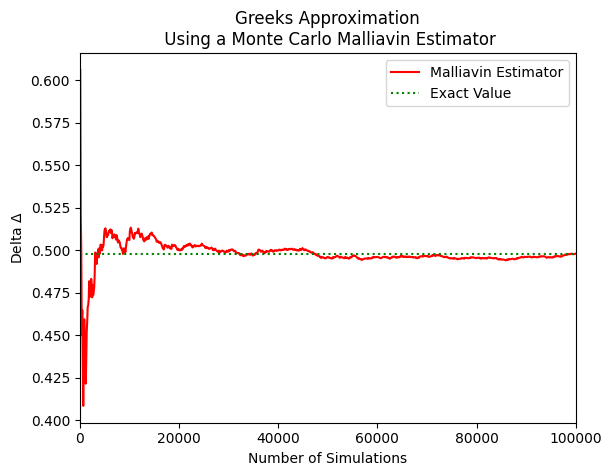

In [12]:
def payoff(x, kind="call"):
    if kind == "call":
        return np.maximum(x-K, 0)
    elif kidn == "put":
        return np.maximum(K - x, 0)
    else:
        return 0

sigma=sigma_prim
x0=S_0
d_plus = (np.log(x0/K)+(r + 0.5*sigma**2)*T)*(1.0/(sigma*np.sqrt(T)))
d_minus = d_plus - sigma*np.sqrt(T)
std_normal = norm(loc=0, scale=np.sqrt(1))
delta = std_normal.cdf(d_plus)


def estimate_delta_malliavin(payoff, r, sigma, x0, T, N):


    browniam_marginal = norm(loc=0, scale=np.sqrt(T))
    brownian_sample = browniam_marginal.rvs(N)
    gbm_sample = x0*np.exp((r - 0.5*sigma**2)*T + sigma*brownian_sample)

    constant = np.exp(-1.0*r*T)/(sigma*x0*T)

    deltas = []
    sizes = range(100, N+1, 100)
    for k in sizes:

        mc_estimator = np.mean(payoff(gbm_sample[:k])*brownian_sample[:k])
        delta = constant*mc_estimator
        deltas.append(delta)


    return sizes, deltas

N = 100000
sizes, malliavin_deltas = estimate_delta_malliavin(payoff=payoff,  r=r, sigma=sigma, x0=x0, T=T, N=N)

plt.rcParams.update(plt.rcParamsDefault)
plt.plot(sizes, malliavin_deltas, color="red", label="Malliavin Estimator")
plt.hlines(delta, 0, sizes[-1], color="green", linestyle=":", label="Exact Value")
plt.xlim([0.0, sizes[-1]])
plt.ylabel("Delta $\Delta$")
plt.xlabel("Number of Simulations")
plt.title("Greeks Approximation\n Using a Monte Carlo Malliavin Estimator")
plt.legend()
plt.show()

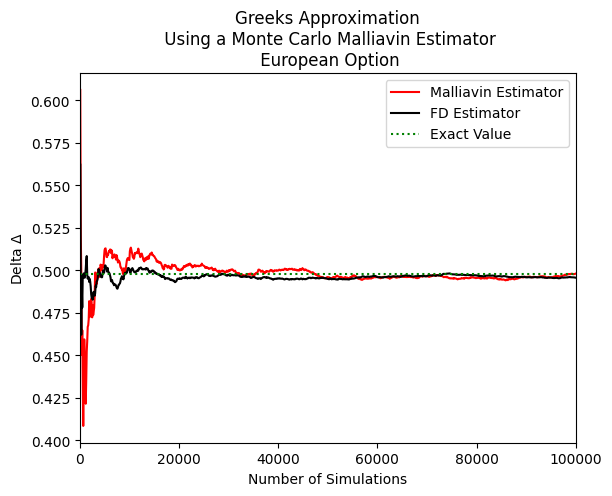

In [13]:
def estimate_delta_fd(payoff, r, sigma, x0, T, N, epsilon=0.001):

    browniam_marginal = norm(loc=0, scale=np.sqrt(T))

    brownian_sample = browniam_marginal.rvs(N)
    gbm_sample_up= (x0 + epsilon)*np.exp((r - 0.5*sigma**2)*T + sigma*brownian_sample)
    gbm_sample_down = (x0 - epsilon)*np.exp((r - 0.5*sigma**2)*T + sigma*brownian_sample)
    constant = np.exp(-1.0*r*T)

    pv_plus = payoff(gbm_sample_up)
    pv_minus = payoff(gbm_sample_down)

    deltas = []
    sizes = range(100, N+1, 100)
    for k in sizes:

        fd = np.mean((pv_plus[:k] - pv_minus[:k])/(2.0*epsilon))
        delta = constant*fd
        deltas.append(delta)

    return sizes, deltas


sizes, fd_deltas = estimate_delta_fd(payoff=payoff, r=r, sigma=sigma, x0=x0, T=T, N=N)

plt.plot(sizes, malliavin_deltas, color="red", label="Malliavin Estimator")
plt.plot(sizes, fd_deltas, color="black", label="FD Estimator")
plt.hlines(delta, 0, sizes[-1], color="green", linestyle=":", label="Exact Value")
plt.xlim([0.0, sizes[-1]])
plt.ylabel("Delta $\Delta$")
plt.xlabel("Number of Simulations")
plt.title("Greeks Approximation\n Using a Monte Carlo Malliavin Estimator\n European Option")
plt.legend()
plt.show()


# Playing around
## 1

Si on prends le modele de black scholes
$$dS_t=S_t\left(rdt+\sigma dB_t\right)$$
Donc
$$S_{n+1}-S_{n}=-\theta_nB(S_n,G_{n+1})$$
avec
$$B(S_n,G_{n+1})=\frac{S_n}{n}\left(r+\sigma \sqrt{n} G_{n+1}\right)$$
et si on fixe $n=N (\text{ maturité } T)$ et on prends
$$B(S_n,G_{n+1})=\frac{S_n}{N}\left(r+\sigma \sqrt{N} G_{n+1}\right)$$

On trouve le processus suivant :

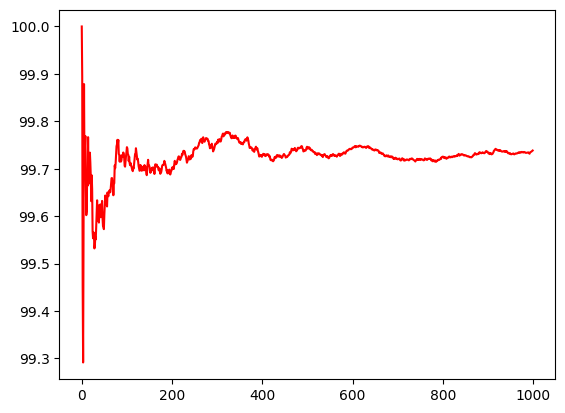

In [ ]:
n=1000

def B(x,u):
    return x*(r/n+sigma_prim/n*np.sqrt(n)*u)


G=np.random.normal(size=n)


cible =100
Y=algorithme_rm_chen(cible,cible*5,n,B,G)
plt.plot(Y,'red')



## 2
On suppose que le prix $S_t$ d'une action A suit la dynamique suivante:

$$dS_t=rS_t+\sigma dB_t$$



On alors avec $d_t=1/n$ et $\theta_n=\frac{1}{\sqrt{n}}$
$$S_{n+1}-S_{n}=-\theta_nB(S_n,G_{n+1})$$
avec
$$B(S_n,G_{n+1})=-S_nnr-\sigma \frac{n}{\sqrt{n}} G_{n+1}$$



In [ ]:
def algorithme_rm_chen_martingal(x_0,MAX,t,F,G):
    X=np.zeros(t);
    X[0] = x_0;
    for i in range(1,t-1):
        X[i+1]=X[i]-gamma(i)*F(X[i],G[i],i)
        if(abs(X[i+1]) >= MAX):
            X[i+1]=0
    return X


In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 64em; }</style>"))

n=10000


def F(x,U,n):
    return x*r/n+sigma_prim*1*np.sqrt(n)*U


def Bi(x,U,n):
    return x*r*1+sigma_prim*U


def B(x,u,i):
    return -x*r*i-sigma_prim*np.sqrt(i)*u
    #return np.exp((r-sigma_prim**2/2)*i+sigma_prim*np.sqrt(i)*u)

G=np.random.normal(size=n)

def algorithme_rm_chen_Price(x_0,MAX,n,F,G):
    X=np.zeros(n);
    X[0] = x_0;
    for i in range(1,n-1):
        X[i+1]=X[i]-gamma(i)*F(X[i],G[i],i)
        if(abs(X[i+1]) >= MAX):
            X[i+1]=0
    return X


target=10
G=np.random.normal(size=2*n)
G2=np.random.normal(size=2*n)
Y=algorithme_rm_chen_martingal(0,2.5*S_0,2*n,F,G)
u=algorithme_rm_chen_martingal(0,2.5*S_0,2*n,F,G)
Z=[x for x in reversed(u)]
plt.figure().set_figheight(4)
plt.plot(Y,'red',Z,'black')
#plt.plot(Z,'black')
plt.show()

n=700
cible =S_0
N=int(2*n)
# G=np.random.normal(size=N)
Y=algorithme_rm_chen_martingal(cible,cible*6.6,N,B,G)
f=max(Y)
U=[y/f for y in Y]
#plt.figure().set_figwidth(4)#(figsize=(6,6))
plt.figure().set_figheight(4)
plt.plot(Y,'red')
plt.show()

NameError: name 'algorithme_rm_chen_martingal' is not defined

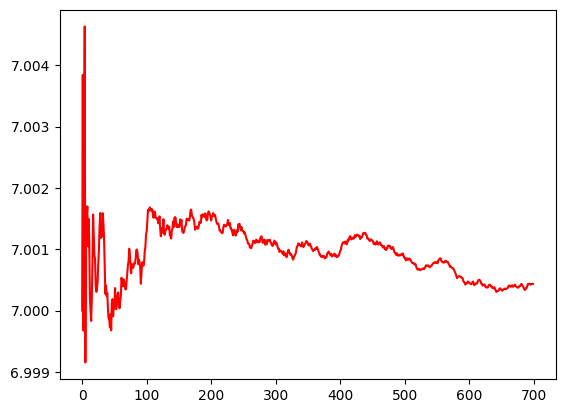

In [ ]:
def B(x,U):
    return x*r/n+sigma*1/np.sqrt(n)*U


def BB(x,U):
    return +(r-sigma_prim**2/2) + sigma_prim*np.sqrt(n)*U

cible=7
G=np.random.normal(size=n)

Y=algorithme_rm_chen(cible,cible*6,n,B,G)

plt.plot(Y,'red')

# END

# Modèle de Black and Scholes et Ajustement de Valorisation stochastique

## Modèle de black scholes

### Méthode Monte Carlo
Soit
$$S_t=\frac{1}{r}\sigma dB_t-\frac{1}{r}dS_t$$

On suppose que le prix $S_t$ d'une action A suit la dynamique suivante:

$$dS_t=S_t\left(rdt+\sigma dB_t\right)$$

Où

$$X_t=ln(S_t)$$

donc

$$dX_t=(r-\frac{\sigma^2}{2})dt+\sigma dB_t$$












Soit $Y_t=exp(-rt+X_t)=exp(-rt)S_t$
donc,

$$dY_t=X_tY_tdt+Y_tdX_t+\frac{1}{2}\sigma^2Y_tdt=Y_t(r-\frac{\sigma^2}{2}dt+\sigma dB_t)+\frac{1}{2}\sigma^2Y_tdt=X_tY_tdt+Y_t\left(rdt+\sigma dB_t\right)$$

donc

$$dY_t=X_tY_tdt+exp(-rt)dS_t=exp(-rt)(S_tln(S_t)+dS_t)$$


On a alors,$$X_{n+1}-X_{n}=(r-\frac{\sigma^2}{2})\frac{1}{n}+\sigma \frac{1}{\sqrt{n}}G=-\theta_nB(S_n,G_{n+1})$$









$$\begin{cases}
      r= 5\text{% : taux d'actualisation} & \\
      \sigma \text{ : la volatilité} & \\
      B_t \text{ : Un mouvement brownien standard, } B_t \sim \mathcal{N}(0,\,t) &
    \end{cases}$$

la solution de cette EDS est la diffusion suivante $\forall t\geq 0$ et $\sigma \in [0,1]$:

$$S_t(\sigma)=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma B_t\right\}=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma \sqrt{t} G\right\}$$

On définit alors le prix d'un call europeen dont le sous jacent est A de la maniere suivante:

$$C(\sigma)=\mathbb{E}\left[e^{-rT}(S_T(\sigma)-K)_+\right]=\mathbb{E}\left[\mathbb{1}_{e^{-rT}(S_T(\sigma)-K)>0}e^{-rT}(S_T(\sigma)-K)\right]$$


On a $\forall t>0$

$$e^{-rT}(S_T(\sigma)-K)>0 \iff S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma B_T\right\}>0$$

$$\iff S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma B_T\right\}>0$$

On a aussi avec $d_t=1/n$ et $\theta_n=\frac{1}{\sqrt{n}}$
$$S_{n+1}-S_{n}=-\theta_nB(S_n,G_{n+1})$$
avec
$$B(S_n,G_{n+1})=\frac{S_n}{n}\left(r+\sigma \sqrt{n} G\right)$$

soit la suite de variable aleatoires
$$V_i=(S_T-K)_{+}=\left(S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma \sqrt{T}G_i\right\}-K\right)_{+}$$
avec
$$t_i=\frac{i}{n} \text{  pour 0$\leq$ i$\leq$ n}$$

Soit
$$M_n=\frac{V_0+....+V_n}{n} \text{, alors, $M_n$ converge présque surement vers } C \text{ le prix d'un call}$$

On a avec $\gamma_n=\frac{1}{n+1}$

$$M_{n+1} = M_n -\gamma_n \left(M_n - V_{n+1}\right)= M_n -\gamma_n F \left(M_n , V_{n+1}\right)$$
En effet,

$$\begin{align*}
M_{n+1}-M_n&=\frac{n\sum_{i=1}^{n+1}V_i-(n+1)\sum_{i=1}^nG_i}{n(n+1)}&\\
&=\frac{V_{n+1}}{n+1}-\frac{M_n}{n+1}&\\
&=-\gamma_n(M_n-V_{n+1})
\end{align*}$$

Soit $f(x)=x-C$  et $x'$ tel que $f(x')=x'-C=0$ et $G$ une gaussienne centrée réduite, donc $\mathbb{E}[G]=0$ et $Var[G]=1$.

On a alors avec $F(x,G)=x-H(\sigma,G)$

avec

$$F(\sigma,G)=e^{-rT}\left(S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma \sqrt{T}G\right\}-K\right)_+$$
donc

$$f(x)=\mathbb{E}[F(x,G)]=x-C$$
